In [2]:
"""
LINMA1170 Homework 4
Authors: -Alexandre Orekhoff
         -Matya Aydin
"""

#Load the necessary libraries
import os.path
#Downloads stopwords
import nltk
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Load the data
#2 datasets are availables
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    Source: https://www.datacamp.com/tutorial/discovering-hidden-topics-python
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r", encoding="utf8") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
            titles.append( text[0:min(len(text),100)] )
    print("Total Number of Documents:",len(documents_list))
            
    return documents_list,titles

#Second dataset
def load_20_newsgroups():
    from sklearn.datasets import fetch_20newsgroups
    newsgroups_train = fetch_20newsgroups(subset='test')
    return newsgroups_train.data, newsgroups_train.target, newsgroups_train.target_names


#Choose your dataset
documents_list, titles = load_data("","articles+4.txt") #Used for report's result
#documents_list, titles_indexes, titles = load_20_newsgroups()

Total Number of Documents: 4551


In [4]:
#Preprocessing:
#We remove stop words
#We stem articles (e.g words such as run, runner, running will be tokenized as a single word)
def preprocess_data(doc_set):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    Source: https://www.datacamp.com/tutorial/discovering-hidden-topics-python
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

#preprocess_storage = "preprocess_storage_20newsgroup.txt" # or None
preprocess_storage = None

texts = None

if preprocess_storage is not None and os.path.exists(preprocess_storage):
    with open(preprocess_storage, "r") as f:
        texts = [line.strip() for line in f.readlines()]
else:
    texts = [" ".join(t) for t in preprocess_data(documents_list)]


In [10]:
def compute_svd(texts, k, Normalize):
    """
    Computes the term-document matrix using a TF-IDF weighting and apply a sparse svd on it
    Normalize is a boolean that allows to normalize each column
    """

    tfidf = None
    
    if Normalize:
        tfidf = TfidfVectorizer(norm='l2')
    else:
        tfidf = TfidfVectorizer()

    doc_term_matrix = tfidf.fit_transform(texts)
    # Keeps track of words meaning
    features_name = tfidf.get_feature_names_out()
    #To get the right format for SVD
    doc_term_matrix_svd = np.transpose(doc_term_matrix.toarray())

    #SVD
    U, S, V = svds(doc_term_matrix_svd, k=k)
    
    return U, S, V, features_name, tfidf

"""
Disclaimer: since scipysvds has a random start (https://stackoverflow.com/questions/30286014/scipy-linalg-deterministic-non-deterministic-code)
Results may vary and one's should rerun this cell to obtain clever results
"""

k = 6 #to adapt #6 for report's result
U, S, V, features_name, tfidf = compute_svd(texts, k, False) #compute_svd(texts, k, False) for report's result




In [11]:
def get_topic(U, features_name, tol, UseAbs, plot):
    """
    Returns k lists corresponding to words associated to each concept
    tol is a float that determines wether we select the word or not
    UseAbs is a boolean to use the absolute to classify each word
    plot is a boolean to plot the 2D classification
    """
    
    
    #Lists of words associated to a concept
    concepts = [[] for _ in range(len(U[0]))]
    
    for j in range(len(U[0])):
        for i in range(len(U)):
            if UseAbs:
                if np.abs(U[i, j]) >= tol:
                    concepts[j].append(features_name[i])
                          
            else:
                if U[i, j] >= tol:
                    concepts[j].append(features_name[i])
                    #Adjust indexes to see the separation between 2 others topics
                    if (j == 0 or j == 2) and plot:
                        plt.scatter(U[i, 0], U[i,2])
                        plt.text(U[i, 0], U[i,2], features_name[i])
                        

    if plot:                
        #2-D plot of words-separation by concepts
        plt.axhline(y = tol, color = 'r', linestyle = '--', label="Topic 2 tolerance") 
        plt.axvline(x = tol, color = 'blue', linestyle = '--', label= "Topic 1 tolerance") 
        plt.xlabel("Topic 1")
        plt.ylabel("Topic 2")
        plt.legend(loc="lower left")
        plt.savefig("topics2d.pdf")
        plt.show()
    
    return concepts

tol = 0.08 #To adapt #0.08 for report's result and useabs = False
topics = get_topic(U, features_name, tol, False, False) 

for topic in topics:
    print(topic, "\n")
    
    

    
    

def get_documents(word, tolerance, UseAbs):
    """
    Retrieve articles associated to a word
    word should be in lower case
    tol is a float to determine which articles we return
    """
    
    topic_titles = []
    
    idx_topic = -1
    for i in range(len(topics)):
        if word in topics[i]:
            idx_topic = i
            break
            
            
    if idx_topic == -1:
        print("did not find the word, try another one")
        
        
    
    for j in range(len(V[idx_topic,:])):
        if UseAbs:
            if np.abs(V[idx_topic, j]) >= tolerance:
                topic_titles.append(titles[j])
        else:
            if V[idx_topic, j] >= tolerance:
                topic_titles.append(titles[j])
        
    return topic_titles, idx_topic
    

word = "trump" #To adapt
tol = 0.03 #To adapt


articles, _ = get_documents(word, tol, False)

for article in articles:
    print(article, "\n")



#plot of the number of articles returned:
"""
start = np.min(V[4,:])
end = np.max(V[4,:])
dom = np.linspace(-0.025, 0.07, 50)
value = np.zeros(50)

idx = 0
for tolerance in dom:
    articles, _ = get_documents(word, tolerance, False)
    value[idx] = len(articles)
    idx +=1
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel("Tolerance [-]")
plt.ylabel("Number of articles returned [-]")
plt.title("Number of articles returned wrt tolerance")
plt.plot(dom, value)
plt.savefig("nbarticles.pdf")
plt.show()
"""

    



['care', 'doctor', 'health', 'hospit', 'junior', 'medic', 'mental', 'nh', 'patient', 'servic'] 

['album', 'care', 'doctor', 'film', 'health', 'mental', 'music', 'nh', 'patient', 'peopl', 'song'] 

['bank', 'custom', 'deutsch', 'financi', 'rate', 'rb', 'trump'] 

['ball', 'club', 'film', 'game', 'goal', 'leagu', 'leicest', 'liverpool', 'min', 'play', 'player', 'premier', 'season', 'team'] 

['clinton', 'cruz', 'donald', 'elect', 'hillari', 'presid', 'republican', 'sander', 'trump'] 

['bank', 'brexit', 'campaign', 'clinton', 'eu', 'like', 'one', 'peopl', 'said', 'say', 'trump', 'uk', 'vote', 'would', 'year'] 

Barclays' defiance of US fines has merit Barclays disgraced itself in many ways during the pre-finan 

Merkel can't afford Deutsche Bank crisis to get out of hand Tidjane Thiam, the former Prudential chi 

Markets relaxed as state aid looms for Italy's Monte dei Paschi – as it happened A surge in the bank 

Watchdog demands banking overhaul to save customers money A package of me

'\nstart = np.min(V[4,:])\nend = np.max(V[4,:])\ndom = np.linspace(-0.025, 0.07, 50)\nvalue = np.zeros(50)\n\nidx = 0\nfor tolerance in dom:\n    articles, _ = get_documents(word, tolerance, False)\n    value[idx] = len(articles)\n    idx +=1\n#plt.xscale(\'log\')\n#plt.yscale(\'log\')\nplt.xlabel("Tolerance [-]")\nplt.ylabel("Number of articles returned [-]")\nplt.title("Number of articles returned wrt tolerance")\nplt.plot(dom, value)\nplt.savefig("nbarticles.pdf")\nplt.show()\n'

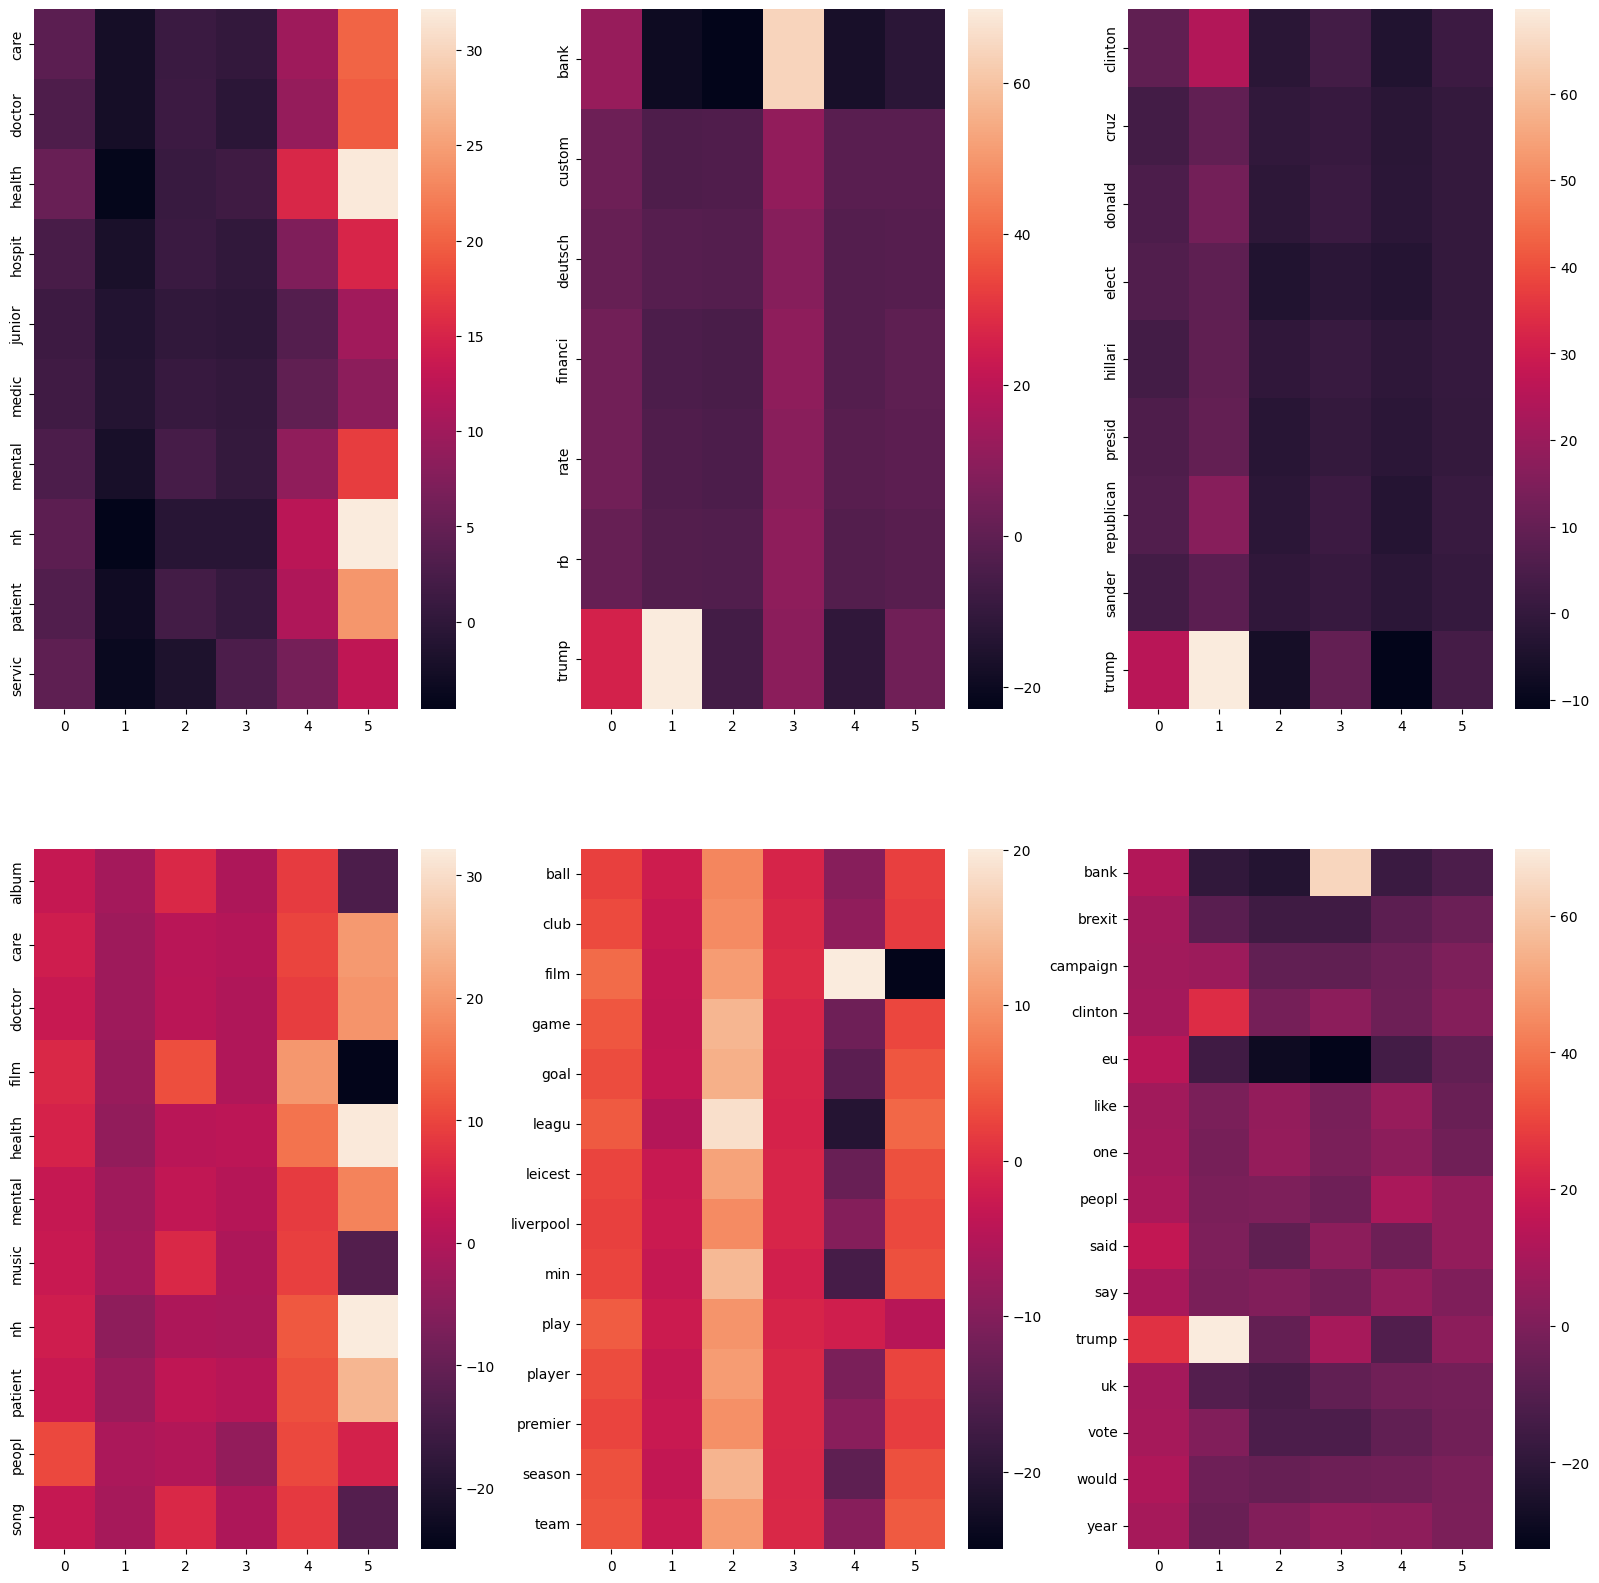

In [12]:
#Since scipy sparse SVD returns singular values in decreasing order, we reverse the diagonal and the associated singular vectors in U and V:
n = len(S)
U[:,:] = U[:, ::-1]
S = S[::-1]
V[:, :] = V[::-1, :]


#Heatmap plot for each concept
feat_name_list = list(features_name)
n = len(feat_name_list)
fig, axes = plt.subplots(2, k//2  + k % 2, figsize=(20, 20))
i = 0
for topic in topics:
    if len(topic) == 0:
        continue
    indexes = [feat_name_list.index(word) for word in topic]
    sns.heatmap(100*U[indexes,:], yticklabels=features_name[indexes], ax=axes[i%2, i//2])#, vmin=-1, vmax=0.5)
    i+=1
#plt.savefig("heatmapstopics.pdf")
plt.show()    

In [15]:
def retrieve(q, U, S, V):
    """
    Input  : querytokens, S, V
    Purpose: retrieve the most relevant documents
    Output : list of relevant documents
    """
    q = q.T @ U @ np.diag(1/S)
    q /= np.linalg.norm(q)
    idx = np.argsort(q @ V)[::-1]
    return idx

tokens = ["computer", "financ", "home", "bike"]
words = [a for a in tfidf.get_feature_names_out()]
tokens_idx = []
for word in tokens:
    if word in words:
        tokens_idx.append(words.index(word))
    else:
        print("Word not found in the dictionary:", word)
        tokens.remove(word)
tokens_idx = np.array(tokens_idx).reshape(len(tokens), 1)

query_input = np.zeros((U.shape[0], 1))
query_input[tokens_idx] = 1
idx = retrieve(query_input, U, S, V)[0, :5]
print(idx)



[2529 1481 3595 4043  887]


In [17]:
def retrieve(q, U, S, V):
    """
    Input  : querytokens, S, V
    Purpose: retrieve the most relevant documents
    Output : list of relevant documents
    """
    q = q.T @ U @ np.diag(1/S)
    q /= np.linalg.norm(q)
    idx = np.argsort(q @ V)[::-1]
    return idx

tokens = ["computer", "financ", "home", "bike"]
tokens_idx = []

for word in tokens:
    if word in words:
        print("Word found in the dictionary:", word)
        tokens_idx.append(words.index(word))
    else:
        print("Word not found in the dictionary:", word)
tokens_idx = np.array(tokens_idx).reshape(len(tokens_idx), 1)
if len(tokens_idx) == 0:
    print("No word found in the dictionary")
else:
    query_input = np.zeros((U.shape[0], 1))
    query_input[tokens_idx] = 1
    idx = retrieve(query_input, U, S, V)[0, :5]
    print(idx)
    #print(np.array(titles)[np.array(titles)[idx]])


Word found in the dictionary: computer
Word found in the dictionary: financ
Word found in the dictionary: home
Word found in the dictionary: bike
[2529 1481 3595 4043  887]
